In [1]:
import pandas as pd
import numpy as np
import random
import math
from numpy import random
import cmath
import matplotlib.pyplot as plt

In [2]:
# Load datasets related to Base Stations, UAVs, and Clients
base = pd.read_csv(r'BS_data.csv')
uav = pd.read_csv(r'UAV_data.csv')
people = pd.read_csv(r'people_data.csv')
IRS=pd.read_csv(r'IRS_data.csv')
p_km_UP=pd.read_csv(r'P_km_up.csv')

Angle_df=pd.read_csv(r'Angle.csv') # number of IRS is 500 store in each column
h_l_km_df=pd.read_csv(r'h_l_km.csv') # number of IRS is 500 store in each column
h_l_m_df=pd.read_csv(r'h_l_m.csv') # number of IRS is 500 store in each column

Angle_UP_df=pd.read_csv(r'Angle1.csv') # number of IRS is 500 store in each column
g_l_km_df=pd.read_csv(r'h_l_km1.csv') # number of IRS is 500 store in each column
g_l_m_df=pd.read_csv(r'h_l_m1.csv') # number of IRS is 500 store in each column # corrected filename

Angle_har_df=pd.read_csv(r'Angle2.csv') # number of IRS is 500 store in each column
f_l_km_df=pd.read_csv(r'h_l_km2.csv') # number of IRS is 500 store in each column
f_l_m_df=pd.read_csv(r'h_l_m2.csv') # number of IRS is 500 store in each column # corrected filename
f_km1=pd.read_csv(r'f_km.csv')

In [7]:
# Constants
Wl_value = 35.28
H_value= 20
P_m_har = base['P_m_har']
T_m_har = base['T_m_har']
P_m_down = base['P_m_down']
f_km=f_km1['0']
V_lm_vfly = uav['V_lm_vfly']
V_lm_hfly = uav['V_lm_hfly']
D_l_hfly = 100

P_km_up=p_km_UP['0']
p_max=10 # moved inside loop
p_km_max=10
T_m=10
D_m_current=0.49


# Additional constants for calculations
delta = 2
Ar = 0.1256
s = 0.05
Nr = 4
V_tip = 102
Cd = 0.022
Af = 0.2113
D_km = 0.5
# Dm=0.49
B=10 #MHz
sigma_km=10**(-13)
eta=10
kappa=0.5
num_population=50
Bh = (1 - 2.2558 * pow(10, -5) *H_value)**4.2577
# Bh = max(1, Bh)
p_l_b = (delta / 8) * Bh * Ar * s * pow(V_tip, 3)

In [8]:
# Determine the maximum possible rows based on the smallest dataframe size
min_rows = min(len(Angle_df), len(h_l_km_df), len(h_l_m_df), len(Angle_UP_df), len(g_l_km_df), len(g_l_m_df), len(Angle_har_df), len(f_l_km_df), len(f_l_m_df), len(f_km1))
num_rows_data_files = min_rows # Dynamically set num_rows_data_files based on the smallest dataframe length
population_size = min(50, num_rows_data_files) # Ensure population_size is not larger than available data

In [9]:
# Fitness function to calculate total energy consumption
def Fitness(E_ml_har, E_ml_down, E_ml_UAV):
    return E_ml_har + E_ml_down + E_ml_UAV

# Energy consumption of the UAV-IRS
def E_ml_UAV(P_l_vfly, T_l_vfly, P_lm_hfly, T_l_hfly, P_l_hov, T_lm_hov):
    return P_l_vfly * T_l_vfly + P_lm_hfly * T_l_hfly + P_l_hov * T_lm_hov

# Power calculations for different flight modes
def P_l_vfly(Wl, V_l_vfly, P_l_b, Nr, Ar, Bh):
    temp2 = Nr * Bh * Ar
    temp3 = np.sqrt(V_l_vfly**2 + (2 * Wl) / temp2)
    return ((Wl / 2) * (V_l_vfly + temp3)) + Nr * P_l_b

def P_lm_hfly(P_lm_blade, P_lm_fuselage, P_lm_induced):
    return P_lm_blade + P_lm_fuselage + P_lm_induced

def P_lm_blade(Nr, P_l_b, V_tip, V_lm_hfly):
    return Nr * P_l_b * (1 + ((3 * (V_lm_hfly**2)) / pow(V_tip, 2)))

def P_lm_fuselage(Cd, Af, Bh, V_lm_hfly):
    return (1 / 2) * Cd * Af * Bh * (V_lm_hfly**3)

def P_lm_induced(Nr, Bh, Ar, Wl, V_lm_hfly):
    return Wl * ((np.sqrt((Wl**2) / (4 * (Nr**2) * (Bh**2) * (Ar**2)) + ((V_lm_hfly**4) / 4)) - ((V_lm_hfly**2) / 2))**(1 / 2))

def P_l_hov(Wl, P_l_b, Nr, Ar, Bh):
    temp1 = Nr * P_l_b
    temp3 = np.sqrt(2 * (Nr * Bh * Ar))
    temp4 = ((Wl)**3 / 2) / temp3
    return temp1 + temp4

def T_lm_hov(T_km_com, T_kml_up, T_ml_down):
    return T_km_com + T_kml_up + T_ml_down

def R_ml_down(B,P_m_down,h_ml_worst): #eqation number 7
    temp1=(h_ml_worst*P_m_down) # Consider if min is the correct aggregation. It should be multiplication
    if (1+temp1) <= 0:
        return 0  # Return 0 if log argument is non-positive to avoid error
    return B*math.log2(1+temp1)

def h_ml_worst(h_kml_down,sigma_km): #eqation number 8
    return h_kml_down/(sigma_km) # it will return the sigal value which is minimum of all
            # the value for each itaration

def calculate_exp_i_theta(theta): # part of equation 8
  return cmath.exp(1j * theta)
 # 1j represents the imaginary unit in Python

def h_kml_down(Angle,h_l_m,h_l_km): # part of equation 8
    result=[]
    if isinstance(Angle, float): # Check if Angle is float, if so, return 0 or handle appropriately
        return 0 # Or raise an exception or return a default value as needed

    if not isinstance(Angle, pd.Series): # added check to handle non-series input
        raise TypeError(f"Expected Angle to be pd.Series, got {type(Angle)}")

    for i in range(len(Angle)):
        theta_radians = math.radians(Angle.iloc[i]) # Use iloc for position-based indexing
        results= calculate_exp_i_theta(theta_radians)
        result.append(results)

    diagonal=np.diag(result)
    # Ensure h_l_m and h_l_km are correctly formatted as numpy arrays
    h_l_m_np = h_l_m.to_numpy() # Convert Series to numpy array
    h_l_km_np = h_l_km.to_numpy() # Convert Series to numpy array
    if h_l_m_np.ndim == 1:
        h_l_m_np = h_l_m_np.reshape(-1, 1) # Reshape to 2D if necessary
    if h_l_km_np.ndim == 1:
        h_l_km_np = h_l_km_np.reshape(1, -1) # Reshape to 2D if necessary


    a=np.dot(h_l_km_np,diagonal) # Use numpy arrays for dot product
    b=np.dot(a,h_l_m_np)      # Use numpy arrays for dot product
    final=abs(b[0][0]) # Take absolute value and ensure it's a scalar
    return (final**2)

def R_kml_up(B,P_km_up,h_kml_up,Sub,sigma_m): #eqation number 4
    temp1=(P_km_up*h_kml_up)/ (Sub+(sigma_m))
    return B*math.log2(1+temp1)
#this is inside the equation 4 have to take summation of h_i_up and P_i_up
def sub(P_i_up,h_il_up):
    return P_i_up*h_il_up

def E_km_com(f_km,T_km_com):
    return eta*(10**(-28))*(f_km**3)*T_km_com

def E_kml_up(P_km_up,T_km_up):
    return P_km_up*T_km_up

def E_kml_har(P_m_har,T_m_har,h_km_har):
    return kappa*P_m_har*T_m_har*h_km_har

In [ ]:
num_bs = 5
num_irs_ele=50
num_generation = 10 # Number of generations, increased for GA to evolve
num_uav_irs = 8
population_size = 50 # Population size for GA

# Define keys that should be subjected to crossover and mutation (numerical parameters)
numerical_keys_for_crossover = [
    'P_m_down_value', 'P_m_har_value', 'T_m_har_value',
    'f_km_value', 'V_lm_vfly_value', 'V_lm_hfly_value',
    'P_km_up_value','f_km_value','Angle1_row','Angle_row',
    'Angle2_row',
]

fitness_sums_GA= [] # Store sum of fitness values for each p_max

all_best_combinations = []
all_best_individuals = []

    # Main Genetic Algorithm Loop
for l in range(num_bs):
    all_best_individuals_bs = []
    P_m_har_value = P_m_har.values[l]
    T_m_har_value = T_m_har.values[l]
    P_m_down_value = P_m_down.values[l]

    # Select unique row indices for the current BS

    index_list = list(range(num_rows_data_files)) # Create a list of all indices
    random.shuffle(index_list)
    unique_row_indices = index_list[:population_size]
    # Create dataframes with uniquely selected rows for the current BS

    h_l_km_df_bs = h_l_km_df.iloc[unique_row_indices, :].reset_index(drop=True)
    g_l_km_df_bs = g_l_km_df.iloc[unique_row_indices, :].reset_index(drop=True)
    f_l_km_df_bs = f_l_km_df.iloc[unique_row_indices, :].reset_index(drop=True)
    f_km_bs = f_km[unique_row_indices].reset_index(drop=True)
    # Corrected line: Ensure indices are within bounds of P_km_up
    valid_indices = [i for i in unique_row_indices if i < len(P_km_up)]
    P_km_up_bs = P_km_up.iloc[valid_indices].reset_index(drop=True)


    for k in range(num_uav_irs):
        best_fitness = float('inf')
        best_individual = {}
        population = []
        V_lm_vfly_value = V_lm_vfly.values[k]
        V_lm_hfly_value = V_lm_hfly.values[k]
        D_l_hfly_value = D_l_hfly
        Sub_value=0
        # Corrected loop range to use valid_indices length
        for i in range(len(valid_indices)): # Using length of valid_indices
            h_il_up_value=h_kml_down(Angle_UP_df.iloc[i, :],g_l_m_df.iloc[k, :],g_l_km_df_bs.iloc[i, :]) # Pass Series, corrected index to i
            Sub_value+=sub(P_km_up_bs[i],h_il_up_value)

        # Initialize population
        # Corrected loop range to use valid_indices length
        for i in range(len(valid_indices)): # Using length of valid_indices
            f_km_value = f_km_bs[i] # Use BS-specific f_km
            P_km_up_value = P_km_up_bs[i] # Use BS-specific P_km_up

            Angle_row = Angle_df.iloc[i, :] # Use BS-specific Angle_df
            h_l_m_row = h_l_m_df.iloc[k, :] # Use BS-specific h_l_m_df
            h_l_km_row = h_l_km_df_bs.iloc[i, :] # Use BS-specific h_l_km_df
            Angle1_row = Angle_UP_df.iloc[i, :] # Use BS-specific Angle_UP_df
            g_l_m_row = g_l_m_df.iloc[k, :] # Use BS-specific g_l_m_df
            g_l_km_row = g_l_km_df_bs.iloc[i, :] # Use BS-specific g_l_km_df
            Angle2_row = Angle_har_df.iloc[i, :] # Use BS-specific Angle_har_df
            f_l_m_row = f_l_m_df.iloc[k, :] # Use BS-specific f_l_m_df
            f_l_km_row = f_l_km_df_bs.iloc[i, :] # Use BS-specific f_l_km_df

            # Calculate power values
            P_lm_blade_value = P_lm_blade(Nr, p_l_b, V_tip, V_lm_hfly_value)
            P_lm_fuselage_value = P_lm_fuselage(Cd, Af, Bh, V_lm_hfly_value)
            P_lm_induced_value = P_lm_induced(Nr, Bh, Ar, Wl_value, V_lm_vfly_value)

            # Calculate time and energy values
            T_l_vfly_value = H_value / V_lm_vfly_value
            T_l_hfly_value = D_l_hfly_value / V_lm_hfly_value # Corrected: D_l_hfly / V_lm_hfly
            E_ml_har_value = P_m_har_value * T_m_har_value
            h_kml_down_value=h_kml_down(Angle_row,h_l_m_row,h_l_km_row) # Pass Series
            h_ml_worst_value=h_ml_worst(h_kml_down_value,sigma_km)
            R_ml_down_value=R_ml_down(B,P_m_down_value,h_ml_worst_value)
            T_ml_down_value=D_m_current/R_ml_down_value
            E_ml_down_value = P_m_down_value * T_ml_down_value
            T_km_com_value = D_km / f_km_value
            h_kml_up_value=h_kml_down(Angle1_row,g_l_m_row,g_l_km_row) # Pass Series, using same function, might need different one if logic is different

            R_kml_up_value=R_kml_up(B,P_km_up_value,h_kml_up_value,Sub_value,sigma_km)
            T_km_up_value=D_m_current/R_kml_up_value # equation number 5
            T_lm_hov_value = T_lm_hov(T_km_com_value, T_km_up_value, T_ml_down_value)
            P_l_hov_value = P_l_hov(Wl_value, p_l_b, Nr, Ar, Bh)
            P_l_vfly_value = P_l_vfly(Wl_value, V_lm_vfly_value, p_l_b, Nr, Ar, Bh)
            P_lm_hfly_value = P_lm_hfly(P_lm_blade_value, P_lm_fuselage_value, P_lm_induced_value)
            E_ml_UAV_value = E_ml_UAV(P_l_vfly_value, T_l_vfly_value, P_lm_hfly_value, T_l_hfly_value, P_l_hov_value, T_lm_hov_value)

            # Calculate fitness
            result_fitness = Fitness(E_ml_har_value, E_ml_down_value, E_ml_UAV_value)

            # Store initial population data
            population.append({
                'fitness': result_fitness,
                'data':  {
                    'P_m_down_value': P_m_down_value,
                    'P_m_har_value': P_m_har_value,
                    'T_m_har_value': T_m_har_value,
                    'f_km_value': f_km_value,
                    'T_km_up_value': T_km_up_value,
                    'V_lm_vfly_value': V_lm_vfly_value,
                    'V_lm_hfly_value': V_lm_hfly_value,
                    'P_km_up_value':P_km_up_value,
                    'Angle1_row':Angle1_row,
                    'Angle_row':Angle_row,
                    'Angle2_row': Angle2_row,
                    }
                })

        generations_data = []
        for j in range(num_generation):
            child_population = []
            # Corrected loop range to use valid_indices length
            for x in range(0, len(valid_indices), 2): # Loop through population with step of 2
                if x + 1 >= len(valid_indices): # Check if i+1 is within bounds, if not break to avoid error in accessing population[i+1]
                    break
                # Crossover
                ranodmpopulation=[]
                for i in range(10):
                    ranodmpopulation.append(random.choice(population))
                ranodmpopulation = sorted(ranodmpopulation, key=lambda x: x['fitness'])
                parent1 = ranodmpopulation[0]
                parent2 = ranodmpopulation[1]
                child_data = {}
                for key in parent1['data']:
                    if key in numerical_keys_for_crossover:
                        child_data[key] = parent1['data'][key] # Keep parent1's numerical value
                        if key in ['Angle1_row','Angle_row','Angle2_row']: # Ensure angles are also Series after crossover
                            child_data[key] = pd.Series([random.uniform(1, 180) for _ in range(len(Angle_df.columns))], index=Angle_df.columns)
                        else:
                            child_data[key] = float(parent1['data'][key]) * 0.6 + float(parent2['data'][key]) * (1 - 0.6)
                    else:
                        child_data[key] = float(parent1['data'][key]) * 0.6 + float(parent2['data'][key]) * (1 - 0.6)

                # Mutation
                u = np.random.uniform(0, 1, 1)[0]
                P_mutation = 0.5
                if u < P_mutation:
                    for key in numerical_keys_for_crossover: # Apply mutation only to numerical keys
                            if key in ['Angle1_row','Angle_row','Angle2_row']: # Handle Angle Series
                                child_data[key] = pd.Series(index=Angle_df.columns, dtype='float64') # Initialize empty Series for child
                                for col in Angle_df.columns: # Iterate through each column (angle direction)
                                    child_data[key][col] = random.normal(loc=0, scale=1, size=(1))[0]
                            else:
                                child_data[key] += random.normal(loc=0, scale=1, size=(1))[0] # Reduced scale for smaller perturbations in HC

                # Compute child fitness
                def compute_fitness(data):
                    P_m_down_value = data['P_m_down_value']
                    P_m_har_value = data['P_m_har_value']
                    T_m_har_value = data['T_m_har_value']
                    f_km_value = data['f_km_value']
                    T_km_up_value = data['T_km_up_value']
                    V_lm_vfly_value = data['V_lm_vfly_value']
                    V_lm_hfly_value = data['V_lm_hfly_value']
                    P_km_up_value=data['P_km_up_value']
                    Angle_row = data['Angle_row'] # Retrieve angle row from child data
                    Angle1_row = data['Angle1_row'] # Retrieve angle row from child data
                    Angle2_row = data['Angle2_row'] # Retrieve angle row from child data

                    # Calculate power values
                    P_lm_blade_value = P_lm_blade(Nr, p_l_b, V_tip, V_lm_hfly_value)
                    P_lm_fuselage_value = P_lm_fuselage(Cd, Af, Bh, V_lm_hfly_value)
                    P_lm_induced_value = P_lm_induced(Nr, Bh, Ar, Wl_value, V_lm_vfly_value)

                    # Calculate time and energy values
                    T_l_vfly_value = H_value / V_lm_vfly_value
                    T_l_hfly_value = D_l_hfly_value / V_lm_hfly_value # Corrected: D_l_hfly / V_lm_hfly
                    E_ml_har_value = P_m_har_value * T_m_har_value # Corrected: 


                    h_kml_down_value_compute=h_kml_down(Angle_row,h_l_m_row,h_l_km_row) # Using original Angle_row, h_l_m_row, h_l_km_row for child as well - might need to be based on child data if angles are also part of optimization
                    h_ml_worst_value=h_ml_worst(h_kml_down_value_compute,sigma_km)
                    R_ml_down_value=R_ml_down(B,P_m_down_value,h_ml_worst_value)
                    if R_ml_down_value <= 0: # check if R_ml_down_value is zero or negative
                        R_ml_down_value = 1e-9 # Assign a small positive value to avoid division by zero
                    T_ml_down_value=D_m_current/R_ml_down_value
                    E_ml_down_value = P_m_down_value * T_ml_down_value
                    T_km_com_value = D_km / f_km_value
                    T_lm_hov_value = T_lm_hov(T_km_com_value, T_km_up_value, T_ml_down_value)
                    P_l_hov_value = P_l_hov(Wl_value, p_l_b, Nr, Ar, Bh)
                    P_l_vfly_value = P_l_vfly(Wl_value, V_lm_vfly_value, p_l_b, Nr, Ar, Bh)
                    P_lm_hfly_value = P_lm_hfly(P_lm_blade_value, P_lm_fuselage_value, P_lm_induced_value)
                    E_ml_UAV_value = E_ml_UAV(P_l_vfly_value, T_l_vfly_value, P_lm_hfly_value, T_l_hfly_value, P_l_hov_value, T_lm_hov_value)
                    h_kml_har_value_compute=h_kml_down(Angle2_row,f_l_m_row,f_l_km_row) # Corrected index to Angle2_row
                    E_kml_har_value=E_kml_har(P_m_har_value,T_m_har_value,h_kml_har_value_compute) # Corrected function call for E_kml_har
                    E_kml_com_value = E_km_com(f_km_value, T_km_com_value)
                    E_kml_up_value=E_kml_up(P_km_up_value,T_km_up_value)


                    # Calculate fitness
                    fitness_value = Fitness(E_ml_har_value, E_ml_down_value, E_ml_UAV_value)
                    current_data = {
                        'P_m_down_value': P_m_down_value,
                        'P_m_har_value': P_m_har_value,
                        'T_m_har_value': T_m_har_value,
                        'f_km_value': f_km_value,
                        'T_km_up_value': T_km_up_value,
                        'V_lm_vfly_value': V_lm_vfly_value,
                        'V_lm_hfly_value': V_lm_hfly_value,
                        'P_km_up_value':P_km_up_value,
                        'Angle1_row':Angle1_row,
                        'Angle_row':Angle_row,
                        'Angle2_row': Angle2_row, # Carry forward original index
                                                    }
                    if V_lm_hfly_value>0 and T_m_har_value>0 and T_ml_down_value>0 and T_km_up_value>0 and P_m_har_value<=p_max and P_m_down_value<=p_max and P_km_up_value<=p_km_max and (T_km_com_value+T_km_up_value+T_ml_down_value)<=T_m and f_km_value>0  and E_kml_har_value>=(E_kml_up_value+E_kml_com_value) and V_lm_vfly_value>0:
                        return fitness_value, current_data
                    else:
                        return  float('inf'),{} # Return empty dict instead of float('inf') for data

                child_fitness, child_data1 = compute_fitness(child_data)
                child_population.append({'fitness': child_fitness, 'data': child_data1})

            # Create new population
            new_population = population + child_population
            new_population = sorted(new_population, key=lambda x: x['fitness'])
            population = new_population[:population_size]
            generations_data.append(population[0].copy())
            # print(population[0])

        best_individual_pair = population[0].copy()
        best_individual_pair['generation'] = j + 1 # Use last j from loop, corrected index
        best_individual_pair['type'] = 'GA'
        best_individual_pair['bs_index'] = l
        best_individual_pair['uav_index'] = k
        all_best_individuals_bs.append(best_individual_pair)

        all_best_combinations.append({
            'bs_index': l,
            'uav_index': k,
            'best_fitness': population[0]['fitness'],
            'best_individual': best_individual_pair,
            'generation_fitness': [gen['fitness'] for gen in generations_data],
            'unique_row_indices': unique_row_indices # Store unique_row_indices in best_combinations
        })
        # print(f"Best Fitness for BS {l}, UAV {k}: {population[0]['fitness']:.4f}")

    # Find best individual for current BS across all UAVs
    best_individual_for_bs = min(all_best_individuals_bs, key=lambda x: x['fitness'])
    # print(f"Best Fitness for BS {l} across all UAVs: {best_individual_for_bs['fitness']:.4f}")


# Select the best unique Base station and UAV-IRS pair using Auction based method
combination_lookup = {}
for combination in all_best_combinations:
    if combination['bs_index'] not in combination_lookup:
        combination_lookup[combination['bs_index']] = {}
    combination_lookup[combination['bs_index']][combination['uav_index']] = combination

# Auction-based assignment
best_assignments = []
unassigned_bs = list(range(num_bs))
unassigned_uavs = list(range(num_uav_irs))

while unassigned_bs and unassigned_uavs:
    best_combination_overall = None

    for l in unassigned_bs:
        best_fitness_for_bs = float('inf')
        best_combination_for_bs = None
        for k in unassigned_uavs:
            if l in combination_lookup and k in combination_lookup[l]:
                combination = combination_lookup[l][k]
                if combination['best_fitness'] < best_fitness_for_bs: # Use 'best_fitness' instead of 'best_individual']['fitness']
                    best_fitness_for_bs = combination['best_fitness']
                    best_combination_for_bs = combination

        if best_combination_for_bs:
            if best_combination_overall is None or best_combination_for_bs['best_fitness'] < best_combination_overall['best_fitness']: # Compare with current best overall
                best_combination_overall = best_combination_for_bs

    if best_combination_overall:
        best_assignments.append(best_combination_overall)
        unassigned_bs.remove(best_combination_overall['bs_index'])
        unassigned_uavs.remove(best_combination_overall['uav_index'])

# Print and Plotting
print(f"\n--- Best Unique UAV Assignments (Auction Based Method) ---")
best_pair_for_plot = None
min_fitness_for_plot = float('inf')

sum_fitness_current_p_max = 0 # Sum of best fitness for current p_max
for assignment in best_assignments:
    print(f"\nBest Assignment for BS {assignment['bs_index']}:")
    print(f" UAV Index: {assignment['uav_index']}")
    best_ind = assignment['best_individual']
    print(f" Best Individual:")
    print(f"  Generation: {best_ind['generation']}, Type: {best_ind['type']}")
    print(f"  Fitness: {best_ind['fitness']:.4f}") # Print current best fitness only
    unique_indices_to_print = assignment['unique_row_indices'] # Retrieve unique_row_indices
    for key, value in best_ind['data'].items():
        if isinstance(value, pd.Series):
            print(f"  {key}: Series: \n{value.iloc[unique_indices_to_print]}") # Print sliced Series
        elif isinstance(value, list): # Handle list type values explicitly
            print(f"  {key}: {value}") # print list directly without formatting
        else:
            print(f"  {key}: {value:.4f}") # Format scalar values

    print("-" * 20)
    sum_fitness_current_p_max += best_ind['fitness'] # Sum fitness values

    if assignment['best_individual']['fitness'] < min_fitness_for_plot:
        min_fitness_for_plot = assignment['best_individual']['fitness']
        best_pair_for_plot = assignment

fitness_sums_GA.append(sum_fitness_current_p_max) # Store sum of fitness for this p_max

# Unassigned BS/UAVs
if unassigned_bs:
    print("\n--- Base Stations without Assigned UAVs ---")
    for bs_index in unassigned_bs:
        print(f"  BS {bs_index} : No UAV is assigned")
        print("-" * 20)

if unassigned_uavs:
    print("\n--- UAVs without Assigned Base Stations ---")
    for uav_index in unassigned_uavs:
        print(f"  UAV {uav_index} : No BS is assigned")
        print("-" * 20)


--- Best Unique UAV Assignments (Auction Based Method) ---

Best Assignment for BS 3:
 UAV Index: 3
 Best Individual:
  Generation: 10, Type: GA
  Fitness: 51685.3727
  P_m_down_value: 3.8399
  P_m_har_value: 0.3701
  T_m_har_value: 3.4550
  f_km_value: 9.0319
  T_km_up_value: 0.8302
  V_lm_vfly_value: 68.9780
  V_lm_hfly_value: 65.1616
  P_km_up_value: 8.2885
  Angle1_row: Series: 
36      52.506505
479    145.167243
13      68.948045
61     122.286303
34      26.762397
482     38.010894
339    136.661938
439    176.941979
109     24.882649
395     72.982391
489    157.015704
478     53.660052
421      3.063961
315    153.560032
375     79.542988
312     15.208483
326     55.938896
72      35.574752
300    157.338801
217     81.793039
76     115.513188
103    171.125409
411    119.156568
249      3.108921
390    129.102478
414     51.544316
114    101.331175
438     65.437548
16      61.660541
106    105.641313
278      0.622473
162     15.937660
487     43.146982
368    144.786696
7

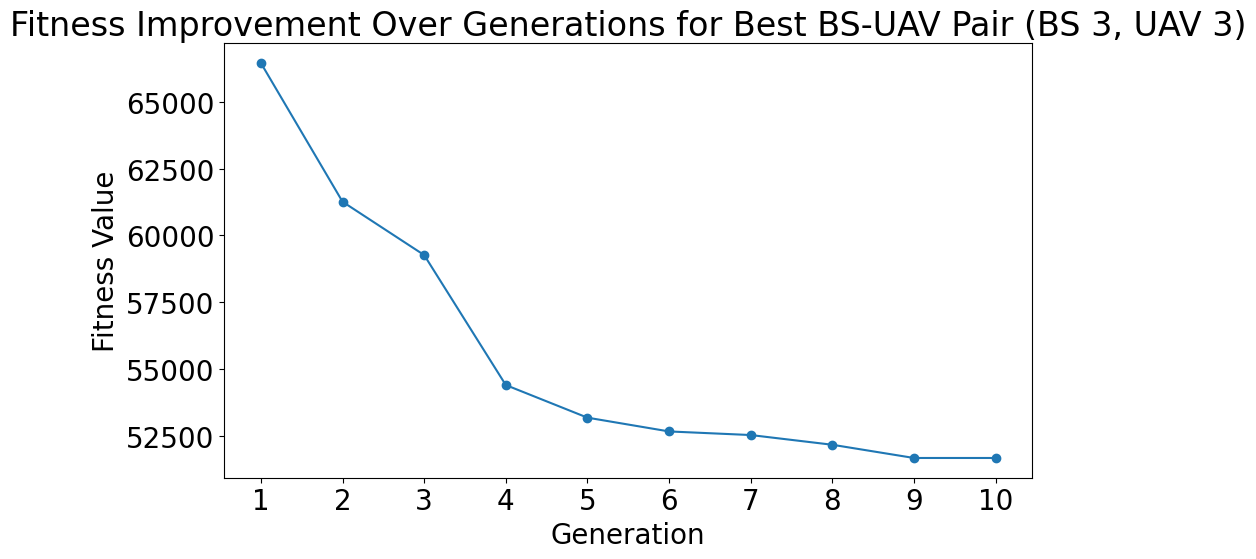

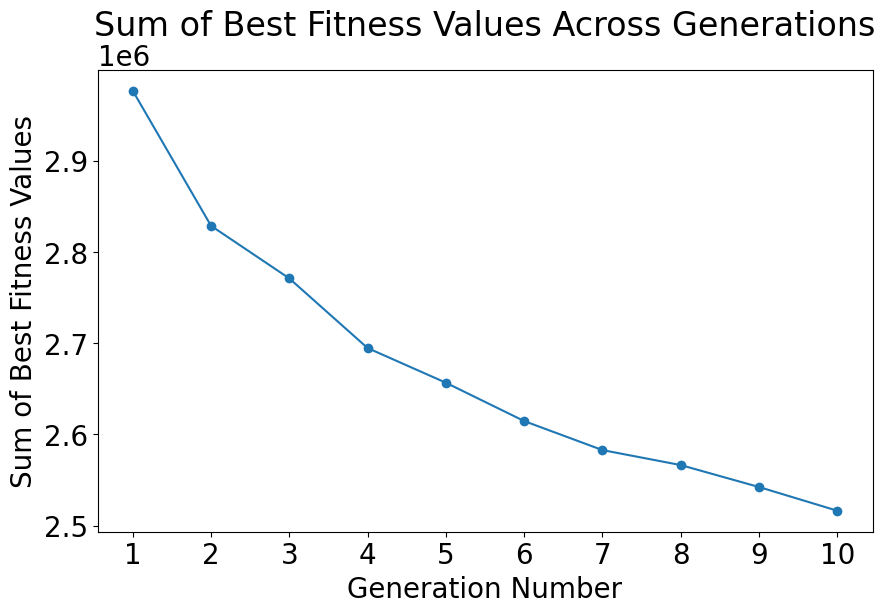

In [11]:
# Plotting graphs
if best_pair_for_plot:
    fitness_history_best_pair = best_pair_for_plot['generation_fitness']
    generations = range(1, num_generation + 1)

    plt.figure(figsize=(10, 6))
    plt.rcParams["font.size"]=20
    plt.plot(generations, fitness_history_best_pair, marker='o', linestyle='-')
    plt.xlabel('Generation')
    plt.ylabel('Fitness Value')
    plt.title(f'Fitness Improvement Over Generations for Best BS-UAV Pair (BS {best_pair_for_plot['bs_index']}, UAV {best_pair_for_plot['uav_index']})')
    plt.xticks(generations)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo best pair found for plotting.")

# Sum of Best Fitness Values Across Generations
best_pair_combination = min(all_best_combinations, key=lambda x: x['best_fitness'])
best_bs_index_plot = best_pair_combination['bs_index']
best_uav_index_plot = best_pair_combination['uav_index']

generations = []
fitness_values = []

sum_fitness_per_generation = [0] * num_generation
for gen_idx in range(num_generation):
    generation_sum = 0
    for combination in all_best_combinations:
        generation_sum += combination['generation_fitness'][gen_idx]
    sum_fitness_per_generation[gen_idx] = generation_sum

generation_indices = list(range(1, num_generation + 1))

plt.figure(figsize=(10, 6))
plt.rcParams["font.size"] = "20"
plt.plot(generation_indices, sum_fitness_per_generation, marker='o', linestyle='-')
plt.title('Sum of Best Fitness Values Across Generations')
plt.xlabel('Generation Number')
plt.ylabel('Sum of Best Fitness Values')
plt.xticks(generation_indices)
plt.show()

